# Flowers-102 Image Classification Model

## Data Pre Processing:

Import libraries:

In [1]:
!pip install torchviz
!pip install torchlens
!pip install torchsummary

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms
from torchvision.datasets import Flowers102
from torchviz import make_dot
from sklearn.metrics import precision_score, f1_score
import torchlens as tl

Calculate actual mean and std of dataset for more accurate transformations:

In [3]:
# Workout actual mean and std of the dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = Flowers102(root='', split='train', transform=transform, download=True)

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in train_dataset:
	channel_sum += torch.mean(img, dim=(1, 2))
	channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
	count += 1

mean = (channel_sum / count).numpy()
std = (torch.sqrt(channel_sum_squared / count - mean ** 2)).numpy()

print("Mean:", mean)
print("Std:", std)

100%|██████████| 344862509/344862509 [00:28<00:00, 12165652.62it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 695127.31it/s]


100%|██████████| 14989/14989 [00:00<00:00, 19261158.90it/s]


Mean: [0.4329607  0.38192013 0.29637718]
Std: [0.29519516 0.24728866 0.2741795 ]


visualise image cropping to ensure too much data isn't lost:

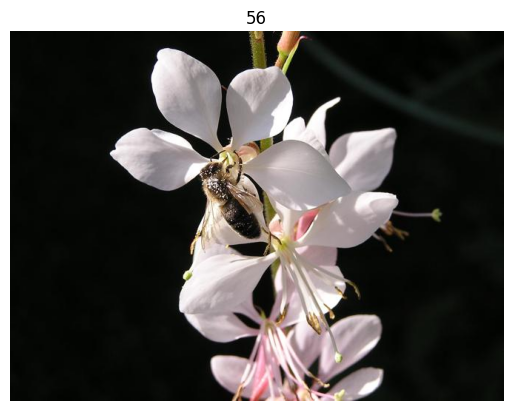

(500, 667, 3)


In [4]:
img, label = train_dataset[567]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()
print(np_img.shape)

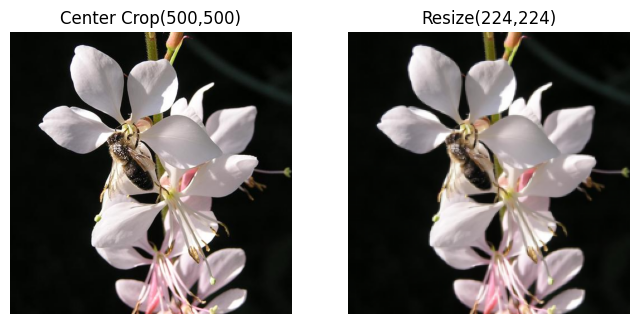

In [5]:
# Images center cropped to 500 and then resized to 224
img, label = train_dataset[567]

center_crop_transform = transforms.CenterCrop(500)
resize_transform = transforms.Resize(224)

img_center_crop = center_crop_transform(img)
img_resize = resize_transform(img_center_crop)

np_img_center_crop = img_center_crop.permute(1, 2, 0).numpy()
np_img_resize = img_resize.permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow((np_img_center_crop * 255).astype('uint8'))
axes[0].set_title('Center Crop(500,500)')
axes[0].axis('off')
axes[1].imshow((np_img_resize * 255).astype('uint8'))
axes[1].set_title('Resize(224,224)')
axes[1].axis('off')

plt.show()

define transforms and apply transformations to data splits:

In [6]:
standard_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transforms_list = [
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
]

# Function to apply a random combination of transforms to each image
class RandomApplyTransforms(object):
    def __init__(self, transforms_list):
        self.transforms_list = transforms_list

    def __call__(self, img):
        for t in self.transforms_list:
            if torch.rand(1) < 0.5:
                img = t(img)
        return img

# Define custom transform that applies a random combination of transforms
custom_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    RandomApplyTransforms(transforms_list),
    transforms.Normalize(mean=mean, std=std),

])

In [7]:
training_data = Flowers102(root='', split='train', transform=custom_transform, download=False)

testing_data = Flowers102(root='', split='test', transform=standard_transforms, download=False)
evaluation_data = Flowers102(root='', split='val', transform=standard_transforms, download=False)

In [8]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


visualise data post transformations:

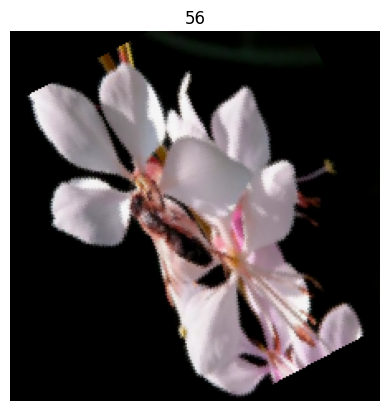

In [9]:
img, label = training_data[567]  # just a random instance to see how the data has been normalised
img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
plt.title(label)
plt.imshow((img * 255).astype('uint8'))
plt.axis('off')
plt.show()

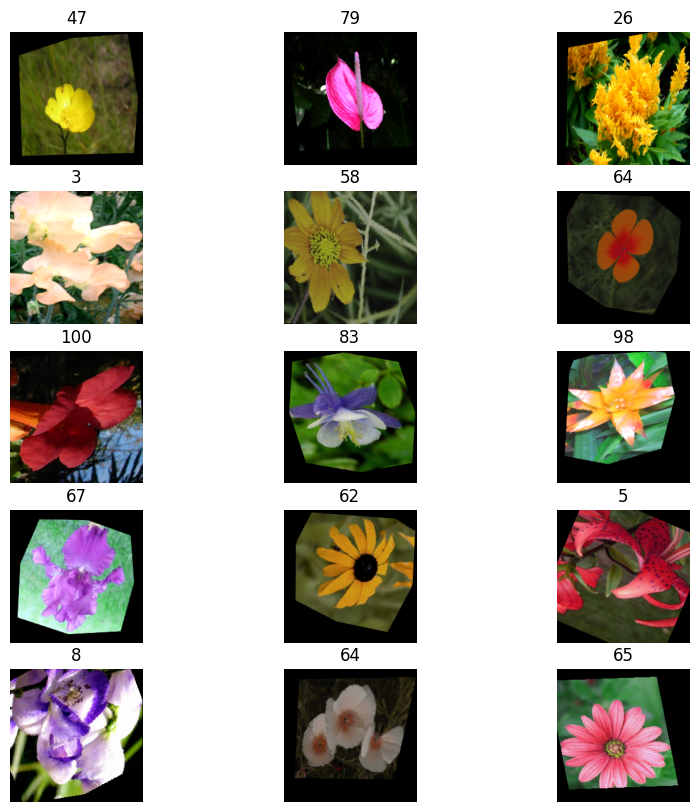

In [10]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	img = (img.squeeze().permute(1, 2, 0).numpy() * std + mean.clip(0, 1))
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

## Define CNN:

In [11]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
		super(FlowerClassifier, self).__init__()
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
		self.bn1 = nn.BatchNorm2d(32)

		self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
		self.bn2 = nn.BatchNorm2d(64)

		self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
		self.bn3 = nn.BatchNorm2d(128)

		self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
		self.bn4 = nn.BatchNorm2d(256)

		self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
		self.bn5 = nn.BatchNorm2d(512)

		self.conv6 = nn.Conv2d(512, 256, kernel_size=3)
		self.bn6 = nn.BatchNorm2d(256)

		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(p=0.025)
		self.flatten = nn.Flatten()
		self.fc = nn.Linear(256, 102)

	def forward(self, x):
		x = self.pool(F.relu(self.bn1(self.conv1(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn2(self.conv2(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn3(self.conv3(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn4(self.conv4(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn5(self.conv5(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn6(self.conv6(x))))
		x = self.flatten(x)
		x = self.fc(x)

		return x

### Training the Data:

Get Device:

In [12]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


Graphs that visualise the training and evaluation losses after training

In [13]:
def plot_graphs(train_losses, eval_losses, eval_accuracies):
	# Plotting the training and evaluation losses
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
	plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training and Evaluation Losses')
	plt.legend()
	plt.show()

	# Plotting the evaluation accuracy
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Validation Accuracy')
	plt.legend()
	plt.show()

### Train and Eval function

In [14]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, patience=15, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []

	best_valid_loss = np.inf
	patience_counter = 0

	start_time = time.time()

	scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)

	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy * 100:.2f}%')

		scheduler.step(evaluation_loss)

		if evaluation_loss < best_valid_loss:
			best_valid_loss = evaluation_loss
			patience_counter = 0
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
				break

	end_time = time.time()
	duration_minutes = (end_time - start_time) / 60

	print(f'Training finished. Time taken: {duration_minutes:.2f} minutes')
	plot_graphs(train_losses, eval_losses, eval_accuracies)

define data loaders, batch size 16

In [15]:
training_loader = DataLoader(training_data, batch_size=16, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=16, shuffle=False)

train model:

Epoch 1/500, Training Loss: 4.4740, Evaluation Loss: 4.1300, Val Accuracy: 9.90%
Epoch 2/500, Training Loss: 4.0678, Evaluation Loss: 3.8638, Val Accuracy: 16.96%
Epoch 3/500, Training Loss: 3.9024, Evaluation Loss: 3.6811, Val Accuracy: 19.51%
Epoch 4/500, Training Loss: 3.7373, Evaluation Loss: 3.5258, Val Accuracy: 24.61%
Epoch 5/500, Training Loss: 3.5711, Evaluation Loss: 3.4038, Val Accuracy: 25.98%
Epoch 6/500, Training Loss: 3.4333, Evaluation Loss: 3.2782, Val Accuracy: 28.73%
Epoch 7/500, Training Loss: 3.3348, Evaluation Loss: 3.1373, Val Accuracy: 30.29%
Epoch 8/500, Training Loss: 3.2475, Evaluation Loss: 3.0953, Val Accuracy: 32.35%
Epoch 9/500, Training Loss: 3.1344, Evaluation Loss: 3.0007, Val Accuracy: 33.33%
Epoch 10/500, Training Loss: 3.0037, Evaluation Loss: 2.9451, Val Accuracy: 34.41%
Epoch 11/500, Training Loss: 2.9152, Evaluation Loss: 2.8711, Val Accuracy: 35.49%
Epoch 12/500, Training Loss: 2.9070, Evaluation Loss: 2.7688, Val Accuracy: 38.53%
Epoch 13/500, 

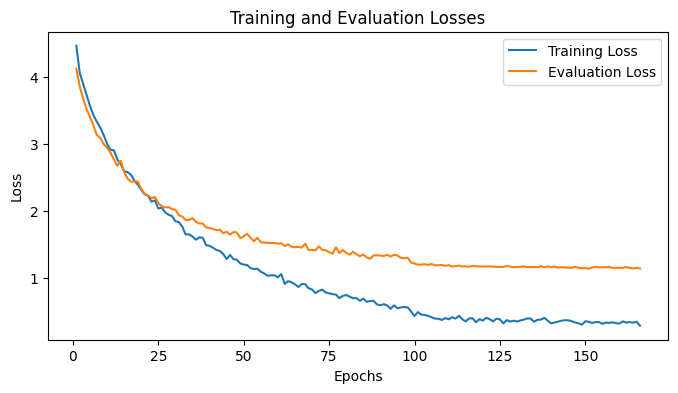

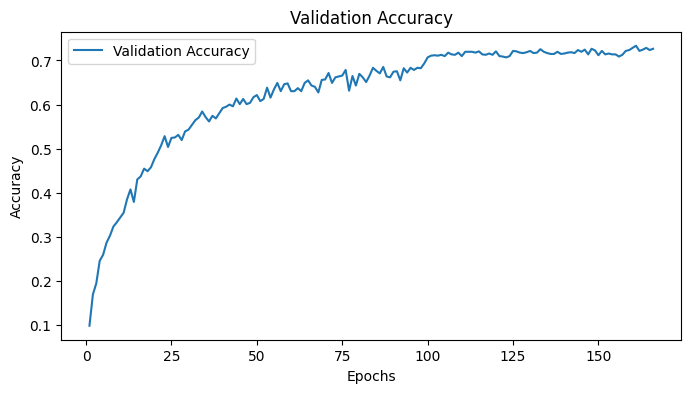

In [16]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=500)

In [17]:
from google.colab import files
torch.save(model.state_dict(), 'flowers-102.pth')
files.download('flowers-102.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# visualise model architecture
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
         MaxPool2d-3         [-1, 32, 111, 111]               0
           Dropout-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 64, 109, 109]          18,496
       BatchNorm2d-6         [-1, 64, 109, 109]             128
         MaxPool2d-7           [-1, 64, 54, 54]               0
           Dropout-8           [-1, 64, 54, 54]               0
            Conv2d-9          [-1, 128, 52, 52]          73,856
      BatchNorm2d-10          [-1, 128, 52, 52]             256
        MaxPool2d-11          [-1, 128, 26, 26]               0
          Dropout-12          [-1, 128, 26, 26]               0
           Conv2d-13          [-1, 256, 24, 24]         295,168
      BatchNorm2d-14          [-1, 256,

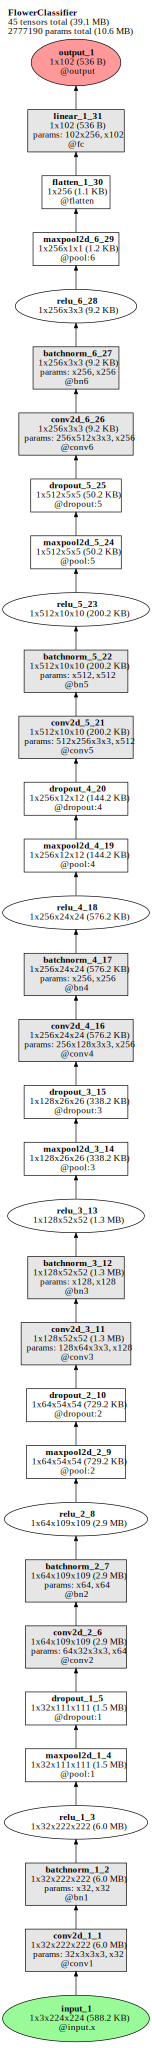

Log of FlowerClassifier forward pass:
	Random seed: 708010665
	Time elapsed: 10.781s (10.773s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- no branching
		- no conditional (if-then) branching
		- contains 12 buffer layers
		- 16 total modules
	Tensor info:
		- 45 total tensors (39.1 MB) computed in forward pass.
		- 45 tensors (39.1 MB) with saved activations.
	Parameters: 13 parameter operations (2777190 params total; 10.6 MB)
	Module Hierarchy:
		conv1
		bn1
		pool:1
		dropout:1
		conv2
		bn2
		pool:2
		dropout:2
		conv3
		bn3
		pool:3
		dropout:3
		conv4
		bn4
		pool:4
		dropout:4
		conv5
		bn5
		pool:5
		dropout:5
		conv6
		bn6
		pool:6
		flatten
		fc
	Layers (all have saved activations):
		  (0) input_1 
		  (1) conv2d_1_1 
		  (2) buffer_1 
		  (3) buffer_2 
		  (4) batchnorm_1_2 
		  (5) relu_1_3 
		  (6) maxpool2d_1_4 
		  (7) dropout_1_5 
		  (8) conv2d_2_6 
		  (9) buffer_3 
		  (10) buffer_4 
		  (11) batchnorm_2_7 
		  (12) relu_2_8 
		  (13) maxpool2

In [19]:
# visualise graph
dummy_input = torch.randn(1, 3, 224, 224).cuda()
output = model(dummy_input)

graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("flowers-102_graph")

model_history = tl.log_forward_pass(model, dummy_input, vis_opt='unrolled')
print(model_history)

## Testing After Training:

### Evaluation function, of final model:

In [20]:
def evaluate(model, data_loader, criterion):
	model.eval()
	evaluation_loss = 0.0
	correct = 0
	total = 0
	misclassified_images = []
	class_counts = {}
	true_labels = []
	predicted_labels = []

	with torch.no_grad():
		for inputs, labels in data_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			evaluation_loss += loss.item() * inputs.size(0)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

			true_labels.extend(labels.cpu().numpy())
			predicted_labels.extend(predicted.cpu().numpy())

			for label in labels.cpu().numpy():
				if label not in class_counts:
					class_counts[label] = 0
				class_counts[label] += 1

			misclassified_inds = (predicted != labels).nonzero()
			for mis_ind in misclassified_inds:
				mis_img = inputs[mis_ind].cpu()
				mis_label = labels[mis_ind].cpu()
				mis_pred = predicted[mis_ind].cpu()
				misclassified_images.append((mis_img, mis_label, mis_pred))

	evaluation_loss /= len(data_loader.dataset)
	evaluation_accuracy = correct / total

	precision = precision_score(true_labels, predicted_labels, average='weighted')
	f1 = f1_score(true_labels, predicted_labels, average='weighted')

	print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy * 100:.2f}%')
	print(f'Precision: {precision:.4f}, F1-score: {f1:.4f}')

	return misclassified_images, class_counts

In [21]:
def list_misclassification_examples_per_class(misclassified_images, class_counts):
	classes_dict = {}
	total_misclassified = 0

	print('Percentage of Misclassified Images Per Flower Type:')

	for _, true_label, pred_label in misclassified_images:
		true_label = true_label.item()
		pred_label = pred_label.item()
		if true_label not in classes_dict:
			classes_dict[true_label] = {"count": 0, "examples": []}
		if classes_dict[true_label]["count"] < 1:
			classes_dict[true_label]["examples"].append(pred_label)
		classes_dict[true_label]["count"] += 1
		total_misclassified += 1

	for true_label, misclassified_info in classes_dict.items():
		total_images = class_counts[true_label]
		misclassification_percentage = (misclassified_info['count'] / total_images) * 100
		print(
			f"True Label: {true_label}, Misclassified Count: {misclassified_info['count']}/{total_images} ({misclassification_percentage:.2f}% Images Incorrectly Classified)")

	print(f"Total Misclassified Images: {total_misclassified}")

Test model on evaluation data:

In [22]:
model = FlowerClassifier().to(device)
model.load_state_dict(torch.load('flowers-102.pth'))

# Test on evaluation data
evaluation_loader = DataLoader(evaluation_data, batch_size=64, shuffle=False)
misclassified_images, class_counts = evaluate(model, evaluation_loader, criterion)
list_misclassification_examples_per_class(misclassified_images, class_counts)

Evaluation Loss: 1.1352, Accuracy: 72.65%
Precision: 0.7292, F1-score: 0.7122
Percentage of Misclassified Images Per Flower Type:
True Label: 0, Misclassified Count: 1/10 (10.00% Images Incorrectly Classified)
True Label: 1, Misclassified Count: 1/10 (10.00% Images Incorrectly Classified)
True Label: 2, Misclassified Count: 9/10 (90.00% Images Incorrectly Classified)
True Label: 3, Misclassified Count: 8/10 (80.00% Images Incorrectly Classified)
True Label: 4, Misclassified Count: 3/10 (30.00% Images Incorrectly Classified)
True Label: 5, Misclassified Count: 1/10 (10.00% Images Incorrectly Classified)
True Label: 6, Misclassified Count: 1/10 (10.00% Images Incorrectly Classified)
True Label: 8, Misclassified Count: 6/10 (60.00% Images Incorrectly Classified)
True Label: 10, Misclassified Count: 7/10 (70.00% Images Incorrectly Classified)
True Label: 11, Misclassified Count: 1/10 (10.00% Images Incorrectly Classified)
True Label: 13, Misclassified Count: 2/10 (20.00% Images Incorrectly

Test model on test data and list number of examples misclassified per class:

In [23]:
test_loader = DataLoader(testing_data, batch_size=64, shuffle=False)

In [ ]:
misclassified_images, class_counts = evaluate(model, test_loader, criterion)
list_misclassification_examples_per_class(misclassified_images, class_counts)

Evaluation Loss: 1.3685, Accuracy: 66.50%
Precision: 0.6982, F1-score: 0.6640
Percentage of Misclassified Images Per Flower Type:
True Label: 0, Misclassified Count: 3/20 (15.00% Images Incorrectly Classified)
True Label: 1, Misclassified Count: 12/40 (30.00% Images Incorrectly Classified)
True Label: 2, Misclassified Count: 11/20 (55.00% Images Incorrectly Classified)
True Label: 3, Misclassified Count: 25/36 (69.44% Images Incorrectly Classified)
True Label: 4, Misclassified Count: 17/45 (37.78% Images Incorrectly Classified)
True Label: 5, Misclassified Count: 2/25 (8.00% Images Incorrectly Classified)
True Label: 6, Misclassified Count: 5/20 (25.00% Images Incorrectly Classified)
True Label: 7, Misclassified Count: 5/65 (7.69% Images Incorrectly Classified)
True Label: 8, Misclassified Count: 11/26 (42.31% Images Incorrectly Classified)
True Label: 9, Misclassified Count: 2/25 (8.00% Images Incorrectly Classified)
True Label: 10, Misclassified Count: 51/67 (76.12% Images Incorrectl

## Load and Test Model:

To test the model without training, load the model from the path and test on the test data.

- (You can run the following code without anything above to evaluate the model.)

In [ ]:
# Libraries needed
import torch
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
# Model architecture
class FlowerClassifier(nn.Module):
	def __init__(self):
		super(FlowerClassifier, self).__init__()
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
		self.bn1 = nn.BatchNorm2d(32)

		self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
		self.bn2 = nn.BatchNorm2d(64)

		self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
		self.bn3 = nn.BatchNorm2d(128)

		self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
		self.bn4 = nn.BatchNorm2d(256)

		self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
		self.bn5 = nn.BatchNorm2d(512)

		self.conv6 = nn.Conv2d(512, 256, kernel_size=3)
		self.bn6 = nn.BatchNorm2d(256)

		self.pool = nn.MaxPool2d(2, 2)
		self.dropout = nn.Dropout(p=0.025)
		self.flatten = nn.Flatten()
		self.fc = nn.Linear(256, 102)

	def forward(self, x):
		x = self.pool(F.relu(self.bn1(self.conv1(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn2(self.conv2(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn3(self.conv3(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn4(self.conv4(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn5(self.conv5(x))))
		x = self.dropout(x)

		x = self.pool(F.relu(self.bn6(self.conv6(x))))
		x = self.flatten(x)
		x = self.fc(x)

		return x

In [ ]:
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=mean, std=std),
])

testing_data = Flowers102(root='', split='test', transform=transform, download=True)

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

In [ ]:
# Load in model from path
model = FlowerClassifier().to(device)
model.load_state_dict(torch.load('flowers-102.pth'))

In [ ]:
def evaluate(model, data_loader, criterion):
	model.eval()
	evaluation_loss = 0.0
	correct = 0
	total = 0

	with torch.no_grad():
		for inputs, labels in data_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			evaluation_loss += loss.item() * inputs.size(0)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

	evaluation_loss /= len(data_loader.dataset)
	evaluation_accuracy = correct / total

	print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy * 100:.2f}%')

In [ ]:
# Test on test data
test_loader = DataLoader(testing_data, batch_size=64, shuffle=False)
evaluate(model, test_loader, criterion)